# Subsection-VIC Plots

First Code Session:

In order to run the code, you will need to ensure that you have all the necessary packages installed, which are in the first code section. Once all the required packages are installed and loaded, you can import the necessary functions using the second code section.

In [1]:
using PyPlot, LinearAlgebra, JuMP, Ipopt, Statistics, Permutations

In [2]:
include("SVIC_code.jl");
include("SVIC_plots.jl");

# Section 6-VIC

The cells below are the settings for plots 10 of the article. The cell below shows the graph used for the results.

# Comparison with Veetaseveera et al example.

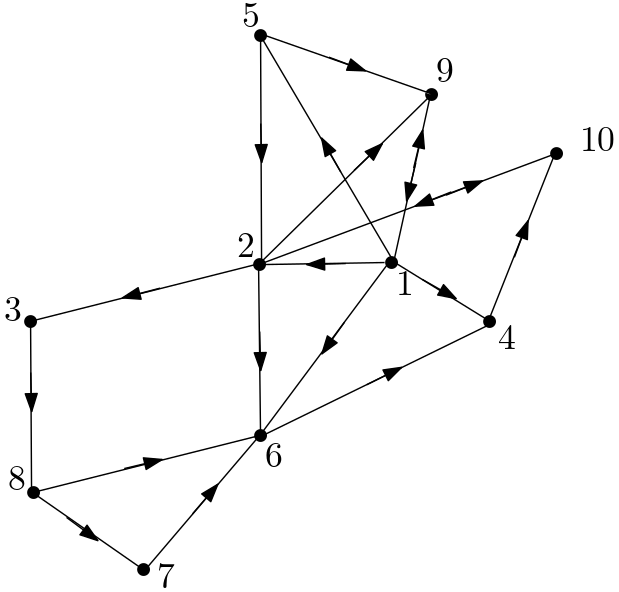

Inside the cells below are the codes for setting the parameters:

In [3]:
#Parameters
#Setting up the adjacency matrix Ad for the graph in Veetaseveera (Fig. 1, p.258)
Ad = Array{Float64}(zeros(10,10));
Ad[1,2] = 1.0;
Ad[1,4] = 1.0;
Ad[1,5] = 1.0;
Ad[1,6] = 1.0;
Ad[1,9] = 1.0;
Ad[2,3] = 1.0;
Ad[2,6] = 1.0;
Ad[2,9] = 1.0;
Ad[2,10] = 1.0;
Ad[3,8] = 1.0;
Ad[4,10] = 1.0;
Ad[5,2] = 1.0;
Ad[5,9] = 1.0;
Ad[6,4] = 1.0;
Ad[7,6] = 1.0;
Ad[8,6] = 1.0;
Ad[8,7] = 1.0;
Ad[9,1]= 1.0;
Ad[9,4] = 1.0;
Ad[10,2] = 1.0;

D_out = diagm([5.0; 4.0; 1.0; 1.0; 2.0; 1.0; 1.0; 2.0; 2.0; 1.0]);
D_in = diagm([1.0; 3.0; 1.0; 3.0; 1.0; 4.0; 1.0; 1.0; 3.0; 2.0]);
L = D_out - Ad;
δ = 0.1;
A = I(10) - δ*L; #This A is row stochastic

x_init = [1;2;-3;0;6;-5;4;3;-2;4];  #Called x_A in Veetaseveera et al.

# Players Targets
x1_hat = 2;
x2_hat = -2;

γ = [0.01;0.02];
u_min = -10;
u_max = 10;

K_f = 100 #horizon
proj_flag = 0;

#Case 3: UB, TA
id = Array{Float64}(I(length(x_init)));

b2_targ = id[:,1] + id[:,2] ;
b1_targ = id[:,5] + id[:,9];

B = [b1_targ b2_targ];
targets = [x1_hat*b1_targ x2_hat*b2_targ];

# DeGroot with Jacobi

First, we show that the DeGroot model with the Jacobi procedure does not present satisfactory results:

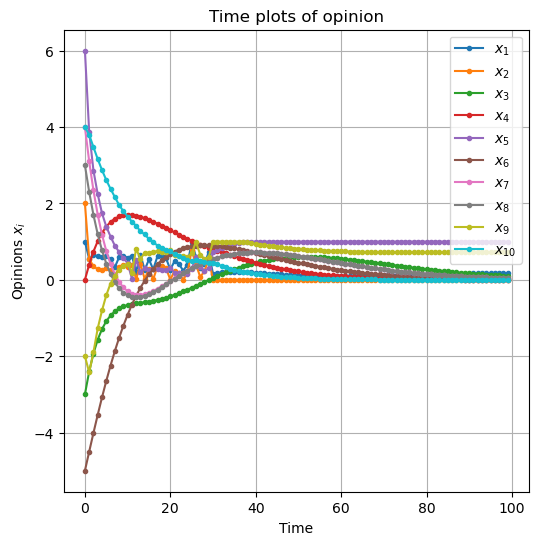

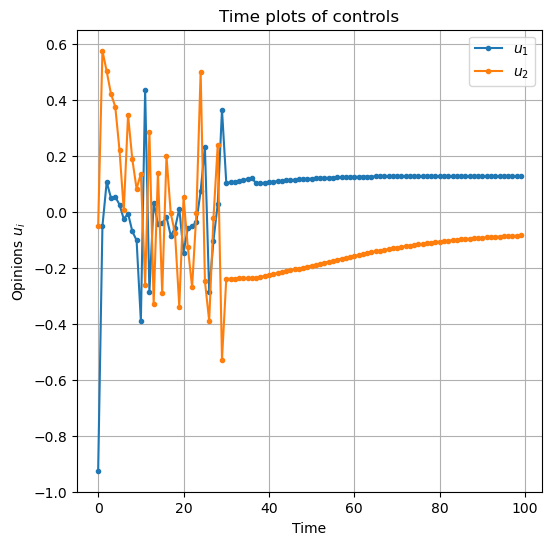

In [5]:
x_os, u_os = COD_OSA_J_targets_DeGroot(x_init,targets,γ,K_f,A,B,u_min,u_max,proj_flag);
plot_horiz = 100;
save_flag_x = 0;
fig_no_x = 6;
save_flag_u = 0;
fig_no_u = 6;
plot_opinions(x_os,plot_horiz,fig_no_x,save_flag_x);
plot_controls(u_os,plot_horiz,fig_no_u,save_flag_u);

# Fig 10
Set "perm_flag = 1".  Due to the random nature of the permutation, the figure may not be as accurate as that in the article, however, it retains the same dynamics and gives a better result in terms of group separation than the Jacobi procedure.

In [6]:
perm_flag = 1;
x_os1, u_os1 = COD_OSA_GS_1p(x_init,targets,γ,K_f,A,B,proj_flag,perm_flag);

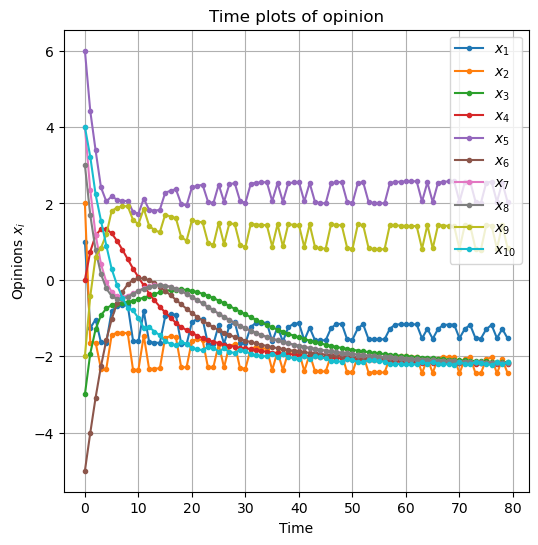

In [7]:
plot_horiz = 80;
save_flag_x = 0; #If == 1, figure will be save
fig_no_x = 7; #Figure name "opinions_$fig_no_u.png"
plot_opinions(x_os1,plot_horiz,fig_no_x,save_flag_x);